In [1]:
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import os
import re
import requests
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns



/Users/karthiksoman/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Set Data path

In [2]:
DATA_PATH = "../../data"


## Custom functions

In [3]:


def extract_unique_dois(text):
    # Pattern to match DOIs inside brackets with 'Ref:' or 'ref:' prefix
    doi_pattern = r'\((?:Ref|ref):\s*(10\.\d+/[^\s\)]+)'
    dois = re.findall(doi_pattern, text, re.IGNORECASE)
    
    # Remove trailing periods and return unique DOIs
    cleaned_dois = [doi.rstrip('.') for doi in dois]
    return list(set(cleaned_dois))

def validate_doi(doi):
    url = f"https://doi.org/{doi}"
    response = requests.get(url, allow_redirects=False)
    return response.status_code == 200 or response.status_code == 302

def analyze_dois_in_passage(passage):
    unique_dois = extract_unique_dois(passage)
    valid_dois = [doi for doi in unique_dois if validate_doi(doi)]
    
    total_unique = len(unique_dois)
    total_valid = len(valid_dois)
    
    fraction = total_valid / total_unique if total_unique > 0 else 0
    
    return {
        'total_unique': total_unique,
        'total_valid': total_valid,
        'fraction_valid': fraction,
        'valid_dois': valid_dois
    }


def calculate_averages_and_sem(data_list):
    zebra_llama = {'Thoroughness': [], 'Accuracy': [], 'Clarity': []}
    base_llama = {'Thoroughness': [], 'Accuracy': [], 'Clarity': []}

    for item in data_list:
        for factor in ['Thoroughness', 'Accuracy', 'Clarity']:
            zebra_llama[factor].append(item['answer 1'][0][factor])
            base_llama[factor].append(item['answer 2'][0][factor])

    zebra_avg = {factor: np.mean(scores) for factor, scores in zebra_llama.items()}
    base_avg = {factor: np.mean(scores) for factor, scores in base_llama.items()}

    zebra_sem = {factor: np.std(scores, ddof=1) / np.sqrt(len(scores)) for factor, scores in zebra_llama.items()}
    base_sem = {factor: np.std(scores, ddof=1) / np.sqrt(len(scores)) for factor, scores in base_llama.items()}

    return zebra_avg, base_avg, zebra_sem, base_sem

def plot_comparison(zebra_avg, base_avg, zebra_sem, base_sem, filename=None):
    factors = ['Clarity', 'Accuracy', 'Thoroughness']
    x = np.arange(len(factors))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 4))
    rects1 = ax.barh(x - width/2, [zebra_avg[factor] for factor in factors], width, 
                     xerr=[zebra_sem[factor] for factor in factors],
                     label='zebra-Llama', color='#4CAF50', alpha=0.7, 
                     error_kw=dict(ecolor='lightgray', capsize=5, capthick=1, elinewidth=1))
    rects2 = ax.barh(x + width/2, [base_avg[factor] for factor in factors], width, 
                     xerr=[base_sem[factor] for factor in factors],
                     label='base-Llama', color='#FFA500', alpha=0.7, 
                     error_kw=dict(ecolor='lightgray', capsize=5, capthick=1, elinewidth=1))

    ax.set_ylabel('')
    ax.set_xlabel('Score', fontsize=16)
    # ax.set_title('Comparison of zebra-Llama and base-Llama')
    ax.set_yticks(x)
    ax.set_yticklabels(factors, fontsize=16)
    ax.legend(fontsize=16)

    # Dynamically set x-axis limits to focus on the data range
    min_value = min(min(zebra_avg.values()), min(base_avg.values()))
    max_value = max(max(zebra_avg.values()), max(base_avg.values()))
    padding = (max_value - min_value) * 0.5  # 10% padding
    # ax.set_xlim(max(0, min_value - padding), min(100, max_value + padding))
    ax.set_xlim(60, min(100, max_value + padding))

    ax.grid(axis='x', linestyle='--', alpha=0.2)
    ax.grid(axis='y', linestyle='--', alpha=0.2)
    # ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=14)



    # Add value labels inside the bars
    def autolabel(rects):
        for rect in rects:
            width = rect.get_width()
            ax.annotate(f'{width:.1f}%',
                        xy=(width, rect.get_y() + rect.get_height()/2),
                        xytext=(-65, 0),  # 5 points horizontal offset to the left
                        textcoords="offset points",
                        ha='right', va='center', 
                        fontsize=12
                       )

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename, format='svg', bbox_inches='tight')



def plot_doi_fraction(df, filename=None):
    # Calculate mean and standard error of the mean (SEM)
    means = df.mean()
    sems = df.sem()

    # Create the plot
    fig, ax = plt.subplots(figsize=(3, 4))

    # Plot bars
    x = np.arange(len(means))
    width = 0.35
    rects = ax.bar(x, means, width, yerr=sems, capsize=5, 
                   color=['#4CAF50', '#FFA500'], alpha=0.7)

    # Customize the plot
    ax.set_ylabel('Per-Response Citation Accuracy (%)', fontsize=14)
    # ax.set_title('Valid DOI Fraction')
    ax.set_xticks(x)
    ax.set_xticklabels(['zebra-Llama', 'base-Llama'], fontsize=14)
    # ax.legend(labels=['zebra-Llama', 'base-Llama'])

    # Set y-axis limits to accentuate differences
    ymin = 20
    ymax = 80
    ax.set_ylim(ymin, ymax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename, format='svg', bbox_inches='tight')    


def plot_perfect_citation_rate(ft_correct, ft_total, bm_correct, bm_total, filename=None):
    # Calculate percentages
    ft_percent = (ft_correct / ft_total) * 100 if ft_total > 0 else 0
    bm_percent = (bm_correct / bm_total) * 100 if bm_total > 0 else 0

    # Create the plot
    fig, ax = plt.subplots(figsize=(3, 4))
    
    # Plot bars
    x = np.arange(2)
    width = 0.35
    rects = ax.bar(x, [ft_percent, bm_percent], width, 
                   color=['#4CAF50', '#FFA500'], alpha=0.7)
    
    # Customize the plot
    ax.set_ylabel('Responses with All Correct Citations (%)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(['zebra-Llama', 'base-Llama'], fontsize=14)
    
    # Set y-axis limits (adjust as needed)
    ymin = max(0, min(ft_percent, bm_percent) - 10)
    ymax = min(100, max(ft_percent, bm_percent) + 10)
    ax.set_ylim(20, 75)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add value labels on top of each bar
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    fig.tight_layout()
    
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    plt.show()

'''
When coming across an article that includes ICC, readers should first check whether information about the ICC form has been reported 
and if an appropriate ICC form was used. 
Based on the 95% confident interval of the ICC estimate, values less than 0.5, between 0.5 and 0.75, between 0.75 and 0.9, 
and greater than 0.90 are indicative of poor, moderate, good, and excellent reliability, respectively.
Ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4913118/
'''

def calculate_differences(evaluation_list):
    differences = []
    for item in evaluation_list:
        zebra_scores = item['answer 1'][0]
        base_scores = item['answer 2'][0]
        diff = {factor: zebra_scores[factor] - base_scores[factor] 
                for factor in ['Thoroughness', 'Accuracy', 'Clarity']}
        differences.append(diff)
    return pd.DataFrame(differences)

def calculate_icc(manual_diff, gpt_diff):
    factors = ['Thoroughness', 'Accuracy', 'Clarity']
    icc_results = {}

    for factor in factors:
        combined_diff = pd.DataFrame({
            'difference': pd.concat([manual_diff[factor], gpt_diff[factor]]),
            'rater': ['manual'] * len(manual_diff) + ['gpt'] * len(gpt_diff),
            'item': list(range(len(manual_diff))) * 2
        })
        
        icc = pg.intraclass_corr(data=combined_diff, targets='item', raters='rater', ratings='difference')
        icc_results[factor] = icc.loc[icc['Type'] == 'ICC3', 'ICC'].values[0]

    return icc_results

## Manual evaluation

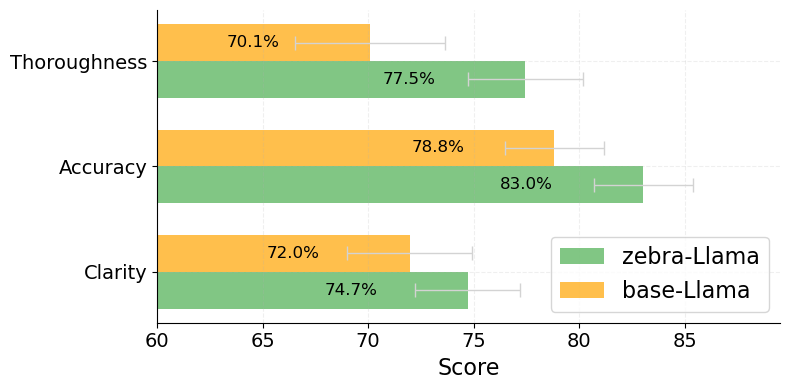

In [4]:
eval_df_1 = pd.read_excel(os.path.join(DATA_PATH, "expert_evaluation_1.xlsx"), engine="openpyxl")
eval_df_2 = pd.read_excel(os.path.join(DATA_PATH, "expert_evaluation_2.xlsx"), engine="openpyxl")
eval_df_3 = pd.read_excel(os.path.join(DATA_PATH, "expert_evaluation_3.xlsx"), engine="openpyxl")


eval_df = pd.concat([eval_df_1, eval_df_2, eval_df_3], ignore_index=True)

evaluation_out_manual = []
for index, row in eval_df.iterrows():
    manual_evaluation_out_dict = {
        "answer 1": [
            {"Thoroughness": row["Thoroughness_answer1"], "Accuracy": row["Accuracy_answer1"], "Clarity": row["Clarity_answer1"]}
        ],
        "answer 2": [
            {"Thoroughness": row["Thoroughness_answer2"], "Accuracy": row["Accuracy_answer2"], "Clarity": row["Clarity_answer2"]}
        ]
    }
    evaluation_out_manual.append(manual_evaluation_out_dict)
    
zebra_avg, base_avg, zebra_sem, base_sem = calculate_averages_and_sem(evaluation_out_manual)
plot_comparison(zebra_avg, base_avg, zebra_sem, base_sem)


## Per-Response Citation Accuracy

51it [00:42,  1.21it/s]

Zebra-Llama per-response citation accuracy = 70.42%
Base-Llama per-response citation accuracy = 52.35%


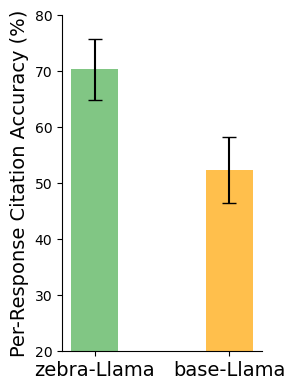

In [5]:

'''
File hackathon_test_data_out_v2.csv is obtained as follows:
1. Run test_on_hackathon_questions.py and save the file "hackathon_test_data_out_v2.joblib"
Then:
   data_loaded = joblib.load("hackathon_test_data_out_v2.joblib")
   ft_response_df = pd.DataFrame(data_loaded["finetuned_model"], columns=["query", "ft_response"])
   bm_response_df = pd.DataFrame(data_loaded["base_model"], columns=["query", "bm_response"])
   ft_bm_response_df = pd.merge(ft_response_df, bm_response_df, on="query", how="outer")
   ft_bm_response_df.to_csv("hackathon_test_data_out_v2.csv", index=False, header=True)   
'''

test_data_with_resp = pd.read_csv(os.path.join(DATA_PATH, "hackathon_test_data_out_v2.csv"))


valid_doi_fraction = []
for index, row in tqdm(test_data_with_resp.iterrows()):
    ft_result = analyze_dois_in_passage(row["ft_response"])
    bm_result = analyze_dois_in_passage(row["bm_response"])
    valid_doi_fraction.append((100*ft_result['fraction_valid'], 100*bm_result["fraction_valid"]))

valid_doi_fraction_df = pd.DataFrame(valid_doi_fraction, columns=["ft", "bm"])

print(f'Zebra-Llama per-response citation accuracy = {round(valid_doi_fraction_df["ft"].mean(),2)}%')
print(f'Base-Llama per-response citation accuracy = {round(valid_doi_fraction_df["bm"].mean(),2)}%')

plot_doi_fraction(valid_doi_fraction_df)

## Response with all correct citations (in %)

51it [00:34,  1.46it/s]


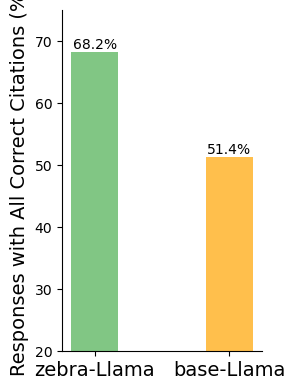

In [6]:
valid_doi_response = []
ft_doi_response_count = 0
bm_doi_response_count = 0
ft_correct_doi_response_count = 0
bm_correct_doi_response_count = 0
for index, row in tqdm(test_data_with_resp.iterrows()):
    ft_result = analyze_dois_in_passage(row["ft_response"])
    bm_result = analyze_dois_in_passage(row["bm_response"])
    if ft_result["total_unique"] > 0:
        ft_doi_response_count += 1
        if ft_result["total_unique"] == ft_result["total_valid"]:
            ft_correct_doi_response_count += 1
    if bm_result["total_unique"] > 0:
        bm_doi_response_count += 1
        if bm_result["total_unique"] == bm_result["total_valid"]:
            bm_correct_doi_response_count += 1

plot_perfect_citation_rate(
    ft_correct_doi_response_count, 
    ft_doi_response_count, 
    bm_correct_doi_response_count, 
    bm_doi_response_count
)
